# Hidden Markov Model on Online Retail Data

This notebook demonstrates how to load, preprocess, and analyze an online retail dataset. We will compute probability distributions and conditional probability tables (CPTs) and then build a Hidden Markov Model (HMM) to model the data. Finally, we will evaluate and visualize the model’s performance.

In [4]:
# Install Dependencies (Only Required Once in Colab)
!pip install ucimlrepo hmmlearn > /dev/null 2>&1

In [31]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder, StandardScaler
# from ucimlrepo import fetch_ucirepo
import seaborn as sns
from hmmlearn import hmm
from sklearn.model_selection import train_test_split


## Data Loading, Exploration, and Cleaning

In this section, we load the online retail dataset from the uploaded Kaggle Retail Dataset (as a csv) file and display some basic metadata and variable information. After getting a brief understanding of the dataset (especially the column names), it is important that we clean the data by doing the following:
* drop unnecessary columns (or columns with data that is not particularly useful),
* set the `CustomerID` for any unknown customers to $-1$,
* set any unlabelled `Product_Category` to be "Other", and
* eliminate any rows for which the quantity purchased or the average price was negative.

Within this cleaning process, we want to verify that the size of the data frame has not changed dramatically, with the lone exception being the possible removal of rows for which there was improper data.

In [8]:
data = pd.read_csv('kaggleRetailData.categorized.csv')

# Display basic info to confirm successful loading
print(data.info())
data = pd.DataFrame(data)
print("Column names (possible variables):", data.columns)

# Drop unnecessary or unhelpful columns
data.drop(['Unnamed: 0'], axis=1, inplace=True)

# Fill missing values
data['CustomerID'].fillna(-1, inplace=True)  # Placeholder for unknown customers
data['Product_Category'].fillna("Other", inplace=True)
data['Coupon_Code'].fillna("No_Coupon", inplace=True)

# Handle potential negative/invalid values
data = data[(data['Quantity'] > 0) & (data['Avg_Price'] > 0)]

print(data.info())
print("Shape of dataframe is:", data.shape)
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52955 entries, 0 to 52954
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           52955 non-null  int64  
 1   CustomerID           52924 non-null  float64
 2   Gender               52924 non-null  object 
 3   Location             52924 non-null  object 
 4   Tenure_Months        52924 non-null  float64
 5   Transaction_ID       52924 non-null  float64
 6   Transaction_Date     52924 non-null  object 
 7   Product_SKU          52924 non-null  object 
 8   Product_Description  52924 non-null  object 
 9   Product_Category     52955 non-null  object 
 10  Quantity             52924 non-null  float64
 11  Avg_Price            52924 non-null  float64
 12  Delivery_Charges     52924 non-null  float64
 13  Coupon_Status        52924 non-null  object 
 14  GST                  52924 non-null  float64
 15  Date                 52924 non-null 

<ipython-input-8-8d216397aee2>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['CustomerID'].fillna(-1, inplace=True)  # Placeholder for unknown customers
<ipython-input-8-8d216397aee2>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,GST,Date,Offline_Spend,Online_Spend,Month,Coupon_Code,Discount_pct
0,17850.0,M,Chicago,12.0,16679.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
1,17850.0,M,Chicago,12.0,16680.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
2,17850.0,M,Chicago,12.0,16696.0,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2.0,122.77,6.5,Not Used,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
3,17850.0,M,Chicago,12.0,16699.0,2019-01-01,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,1.0,81.50,6.5,Clicked,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0
4,17850.0,M,Chicago,12.0,16700.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,153.71,6.5,Clicked,0.1,1/1/2019,4500.0,2424.5,1,ELEC10,10.0


## Analyzing the Dataset and Feature Engineering



This dataset captures customer purchase behavior across various transactions, providing essential features for understanding purchasing trends and improving personalized recommendations. The list of variables is:

| **Variable**               | **Description**                                               | **Data Type** |
|----------------------------|---------------------------------------------------------------|----------------|
| `CustomerID`                | Unique identifier for each customer.                          | Numeric         |
| `Gender`                    | Gender of the customer (e.g., Male, Female).                   | Categorical     |
| `Location`                  | Location or address information of the customer.               | Text            |
| `Tenure_Months`             | Number of months the customer has been associated.              | Numeric         |
| `Transaction_ID`            | Unique identifier for each transaction.                        | Numeric         |
| `Transaction_Date`          | Date of the transaction.                                        | Date            |
| `Product_SKU`               | Stock Keeping Unit (SKU) identifier for the product.            | Text            |
| `Product_Description`       | Description of the product.                                      | Text            |
| `Product_Category`          | Category to which the product belongs.                          | Categorical     |
| `Quantity`                  | Quantity of the product purchased.                              | Numeric         |
| `Avg_Price`                 | Average price of the product.                                    | Numeric         |
| `Delivery_Charges`          | Charges associated with the delivery of the product.             | Numeric         |
| `Coupon_Status`             | Status of the coupon associated with the transaction.            | Categorical     |
| `GST`                       | Goods and Services Tax associated with the transaction.         | Numeric         |
| `Date`                      | Date of the transaction (potentially redundant with `Transaction_Date`).| Date        |
| `Offline_Spend`             | Amount spent offline by the customer.                            | Numeric         |
| `Online_Spend`              | Amount spent online by the customer.                             | Numeric         |
| `Month`                     | Month of the transaction.                                         | Categorical     |
| `Coupon_Code`               | Code associated with a coupon, if applicable.                     | Text            |
| `Discount_pct`              | Percentage of discount applied to the transaction.                 | Numeric         |


### **Feature Engineering**
In order to improve our model performance and align with our recommendation goals, we add the following columns to our data:

- `Days_Since_Last_Purchase` — Introduced to better track customer engagement cycles.
- `Purchase_Month` — Extracted from `Transaction_Date` to model seasonal trends.
- `Used_Coupon` — Binary feature representing whether a coupon was redeemed.
- `Discount_Applied` — Binary feature representing whether a discount was applied in the transaction.

These features will be useful for the Conditional Probability Tables (CPTs) that will contribute to our models and to our agent's ability to make good predictions and to provide reasonable recommendations for a particular customer.

In addition to adding these columns, we rescale some of the columns so that the data are less susceptible to outliers and to increased variability.

In [9]:
# Add new features
data['Total_Spend'] = data['Online_Spend'].fillna(0) + data['Offline_Spend'].fillna(0)
data['Used_Coupon'] = np.where(data['Coupon_Status'] == 'Redeemed', 1, 0)
data['Discount_Applied'] = np.where(data['Discount_pct'] > 0, 1, 0)

# Date conversion and time-based features
data['Transaction_Date'] = pd.to_datetime(data['Transaction_Date'])
data['Days_Since_Last_Purchase'] = (data['Transaction_Date'].max() - data['Transaction_Date']).dt.days
data['Purchase_Month'] = data['Transaction_Date'].dt.month

# Log transformation for skewed data
data['Log_Avg_Price'] = np.log1p(data['Avg_Price'])
data['Log_Quantity'] = np.log1p(data['Quantity'])

# Standardization
scaler = StandardScaler()
data[['Scaled_Tenure_Months']] = scaler.fit_transform(data[['Tenure_Months']])


# Encode categorical variables
encoder = LabelEncoder()
data['Gender_Encoded'] = encoder.fit_transform(data['Gender'])
data['Location_Encoded'] = encoder.fit_transform(data['Location'])
data['Product_Category_Encoded'] = encoder.fit_transform(data['Product_Category'])

# Display the transformed data
print(data.info())
print(data.columns)
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 52924 entries, 0 to 52923
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   CustomerID                52924 non-null  float64       
 1   Gender                    52924 non-null  object        
 2   Location                  52924 non-null  object        
 3   Tenure_Months             52924 non-null  float64       
 4   Transaction_ID            52924 non-null  float64       
 5   Transaction_Date          52924 non-null  datetime64[ns]
 6   Product_SKU               52924 non-null  object        
 7   Product_Description       52924 non-null  object        
 8   Product_Category          52924 non-null  object        
 9   Quantity                  52924 non-null  float64       
 10  Avg_Price                 52924 non-null  float64       
 11  Delivery_Charges          52924 non-null  float64       
 12  Coupon_Status          

,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,...,Used_Coupon,Discount_Applied,Days_Since_Last_Purchase,Purchase_Month,Log_Avg_Price,Log_Quantity,Scaled_Tenure_Months,Gender_Encoded,Location_Encoded,Product_Category_Encoded
0,17850.0,M,Chicago,12.0,16679.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,...,0,1,364,1,5.041552,0.693147,-1.048214,1,1,16
1,17850.0,M,Chicago,12.0,16680.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,...,0,1,364,1,5.041552,0.693147,-1.048214,1,1,16
2,17850.0,M,Chicago,12.0,16696.0,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,2.0,...,0,1,364,1,4.818425,1.098612,-1.048214,1,1,16
3,17850.0,M,Chicago,12.0,16699.0,2019-01-01,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,1.0,...,0,1,364,1,4.412798,0.693147,-1.048214,1,1,16
4,17850.0,M,Chicago,12.0,16700.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1.0,...,0,1,364,1,5.041552,0.693147,-1.048214,1,1,16


In [10]:
np.unique(data['Product_Category'])

array(['Accessories', 'Android', 'Apparel', 'Backpacks', 'Bags',
       'Bottles', 'Drinkware', 'Fun', 'Gift Cards', 'Google', 'Headgear',
       'Housewares', 'Lifestyle', 'More Bags', 'Nest', 'Nest-Canada',
       'Nest-USA', 'Notebooks & Journals', 'Office', 'Waze'], dtype=object)

## Visualizing the Data

Since some of the features will be important for both our model and for our agent, it would be useful to have a more visual understanding for the data.

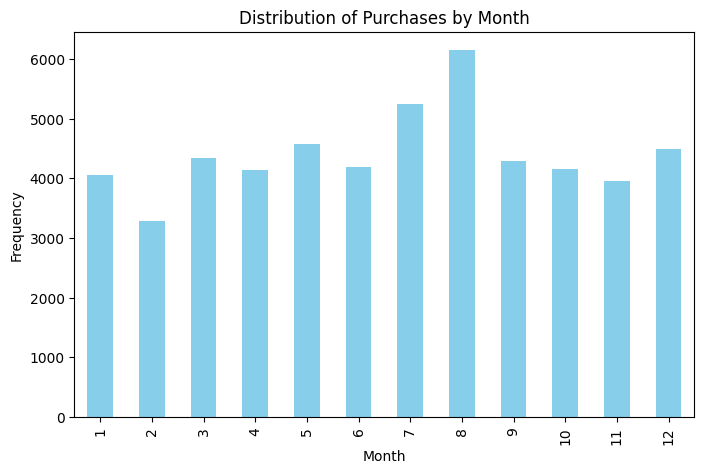

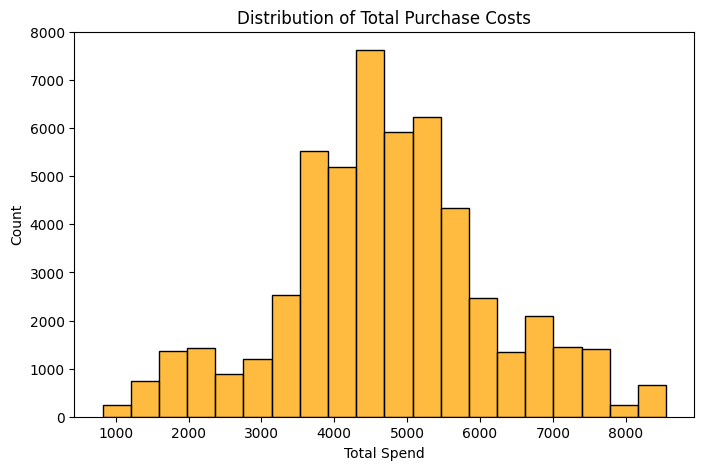

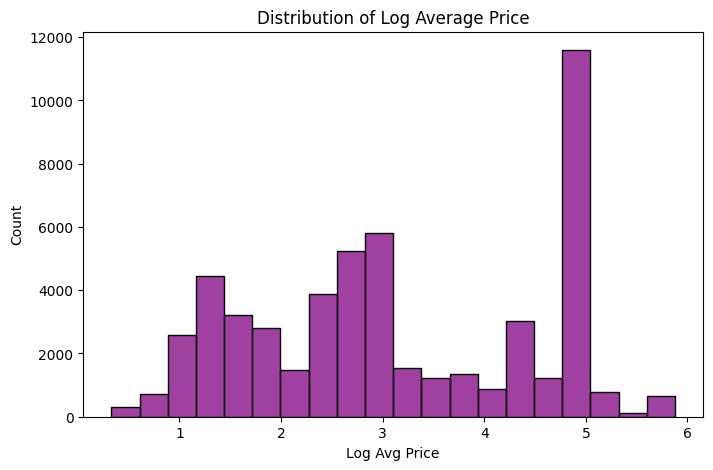

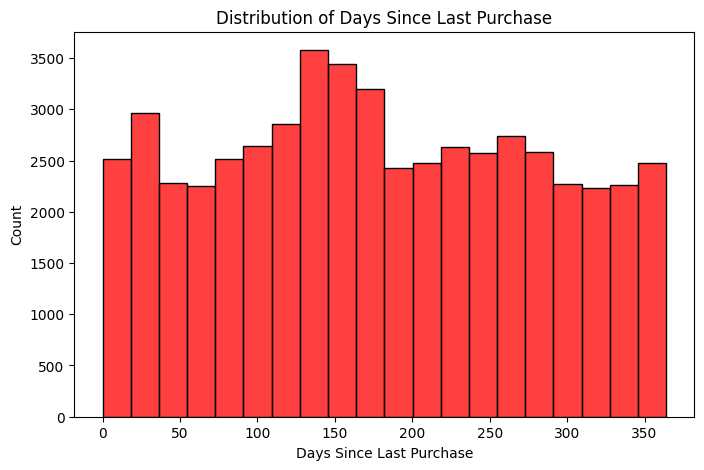

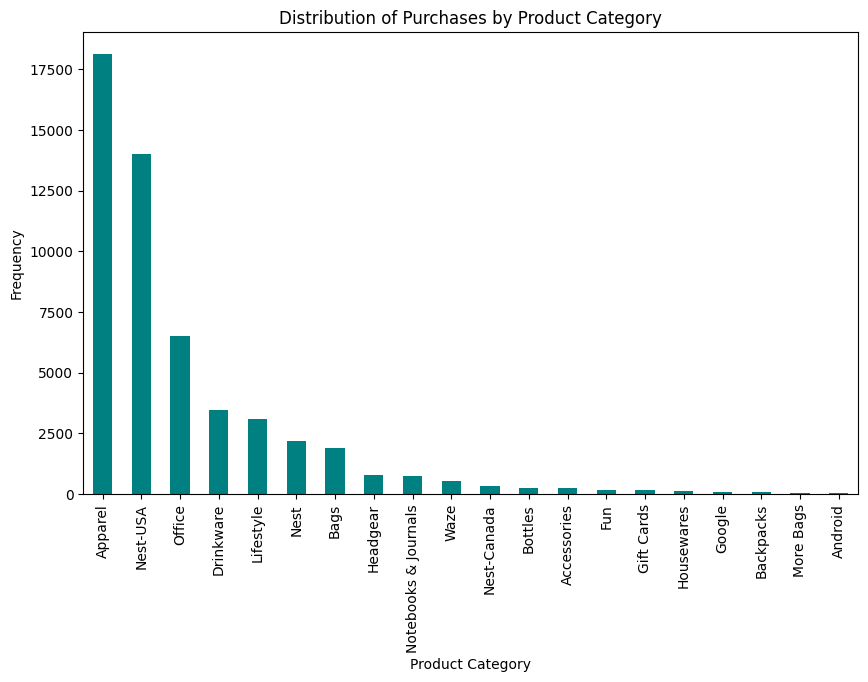

In [11]:
# Distribution of Purchases in Each Month
plt.figure(figsize=(8, 5))
data['Purchase_Month'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Purchases by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

# Distribution of Total Purchase Costs
plt.figure(figsize=(8, 5))
sns.histplot(data['Total_Spend'], bins=20, color='orange')
plt.title('Distribution of Total Purchase Costs')
plt.xlabel('Total Spend')
plt.show()

# Distribution of Log Average Price
plt.figure(figsize=(8, 5))
sns.histplot(data['Log_Avg_Price'], bins=20, color='purple')
plt.title('Distribution of Log Average Price')
plt.xlabel('Log Avg Price')
plt.show()

# Distribution of Days Since Last Purchase
plt.figure(figsize=(8, 5))
sns.histplot(data['Days_Since_Last_Purchase'], bins=20, color='red')
plt.title('Distribution of Days Since Last Purchase')
plt.xlabel('Days Since Last Purchase')
plt.show()

# Distribution of Purchases in Each Product Category
plt.figure(figsize=(10, 6))
data['Product_Category'].value_counts().plot(kind='bar', color='teal')
plt.title('Distribution of Purchases by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Frequency')
plt.show()

### **Model Parameters and Conditional Probability Tables**
Our model parameters are derived from the *Conditional Probability Tables (CPTs)* defined below, which try to capture relationships between certain variables.

Since our agent's goal is to predict and recommend purchases for a given customer, our CPT are designed to prioritize customer-specific dependencies. This shift aligns with the idea that our agent should try to provide personalized recommendations based on past customer behavior. The CPTs are as follows:

| CPT                          | Parameter Definition |
|------------------------------|-----------------------|
| `P(Product_Category \| CustomerID)` | Probability of each product category given a customer. |
| `P(Total_Spend \| CustomerID, Purchase_Month)` | Probability of spending a particular amount by a customer in a particular month. |
| `P(Avg_Price \| CustomerID, Product_Category)` | Probability of paying an average price for a given customer for items in a particular category. |
| `P(Days_Since_Last_Purchase \| CustomerID)` | Probability of a certain number of days elapsing since a given customer last made a purchase. |
| `P(Used_Coupon \| CustomerID, Product_Category)` | Probability that a customer uses a coupon for a given category. |
| `P(Purchased_Month \| Product_Category)` | Probability that an item in a given product category was bought during a particular month. |

---


Each CPT is calculated using grouped frequency counts, means, or normalized probabilities. For CPTs based on categorical probabilities:  

$$ \mathbb{P}(X \,|\, Y) = \frac{\text{Count of } X \text{ in group } Y}{\text{Total observations in group } Y} $$

As an example, consider the probability of a given customer purchasing an item from a specific category:
```python
cpt_productCategory_by_customer = data.groupby('CustomerID')['Product_Category'].value_counts(normalize=True).unstack(fill_value=0)
```

For CPTs based on continuous values like `Avg_Price`, `Quantity`, or `Total_Spend`:  

$$ P(X \,|\, Y) = \frac{\sum_{x'} \text{count } X = x'}{\text{count of observations of } Y} $$

As an example, consider the probability of a given customer purchasing an item in a given product category:
```python
cpt_price_by_customerAndProductCategory = data.groupby(['CustomerID', 'Product_Category'])['Avg_Price'].mean().unstack(fill_value=0)
```

For binary features (e.g., `Used_Coupon`, `Discount_Applied`), probabilities are computed as:

$$ \mathbb{P}(X = 1 \,|\, Y) = \frac{\text{Count of Successful Outcomes for }X}{\text{Total Observations in Group} Y} $$

As an example, consider the probability that a given customer uses a coupon to buy an item from a specific product category:
```python
cpt_coupon_by_customerAndProductCategory = data.groupby(['CustomerID', 'Product_Category'])['Used_Coupon'].mean().unstack(fill_value=0)
```

In [12]:
# CPT, P(Product_Category | CustomerID)
# Given a particular customer, what is the probability that they will purchase from each product category?
cpt_productCategory_by_customer = data.groupby('CustomerID')['Product_Category'].value_counts(normalize=True).unstack(fill_value=0)

# CPT, P(Total_Spend | CustomerID, Purchase_Month)
# Given a particular customer and purchase month, what is the expected total spending for that customer during that month?
cpt_totalSpend_by_customer_month = data.groupby(['CustomerID', 'Purchase_Month'])['Total_Spend'].mean().unstack(fill_value=0)

# CPT, P(Avg_Price | CustomerID, Product_Category)
# Given a particular customer and product category, what is the expected average price of their purchases in that category?
cpt_price_by_customerAndProductCategory = data.groupby(['CustomerID', 'Product_Category'])['Avg_Price'].mean().unstack(fill_value=0)

# CPT, P(Days_Since_Last_Purchase | CustomerID)
# Given a particular customer, what is the expected number of days since their last purchase?
cpt_days_by_customer = data.groupby('CustomerID')['Days_Since_Last_Purchase'].mean()

# CPT, P(Used_Coupon | CustomerID, Product_Category)
# Given a particular customer and product category, what is the probability that the customer will use a coupon for that purchase?
cpt_coupon_by_customerAndProductCategory = data.groupby(['CustomerID', 'Product_Category'])['Used_Coupon'].mean().unstack(fill_value=0)

# CPT, P(Purchase_Month | Product_Category)
# Given a particular product category, what is the probability that an item was bought in a particular month?
cpt_month_by_productCategory = data.groupby('Product_Category')['Purchase_Month'].value_counts(normalize=True).unstack(fill_value=0)

# Display sample CPTs for verification
print("Sample CPT: P(Product_Category | CustomerID)")
display(cpt_productCategory_by_customer.head())

print("Sample CPT: P(Log_Total_Spend | CustomerID, Purchase_Month)")
display(cpt_totalSpend_by_customer_month.head())

print("Encoded Months:", np.unique(data['Purchase_Month']))

Sample CPT: P(Product_Category | CustomerID)


Product_Category,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,Fun,Gift Cards,Google,Headgear,Housewares,Lifestyle,More Bags,Nest,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze
CustomerID,,,,,,,,,,,,,,,,,,,,
12346.0,0.000000,0.0,0.500000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.500000,0.0
12347.0,0.016667,0.0,0.316667,0.0,0.033333,0.0,0.033333,0.0,0.0,0.016667,0.016667,0.0,0.016667,0.0,0.033333,0.000000,0.333333,0.0,0.183333,0.0
12348.0,0.000000,0.0,0.173913,0.0,0.086957,0.0,0.130435,0.0,0.0,0.000000,0.000000,0.0,0.217391,0.0,0.000000,0.000000,0.086957,0.0,0.304348,0.0
12350.0,0.000000,0.0,0.411765,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.117647,0.0,0.000000,0.0,0.000000,0.117647,0.352941,0.0,0.000000,0.0
12356.0,0.000000,0.0,0.416667,0.0,0.027778,0.0,0.083333,0.0,0.0,0.000000,0.000000,0.0,0.111111,0.0,0.055556,0.000000,0.111111,0.0,0.194444,0.0


Sample CPT: P(Log_Total_Spend | CustomerID, Purchase_Month)


Purchase_Month,1,2,3,4,5,6,7,8,9,10,11,12
CustomerID,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,5546.67,0.00,0.000000,0.00
12347.0,0.0,0.0,3984.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,4270.191034,0.00
12348.0,0.0,0.0,0.0,0.0,0.0,5717.07,0.0,0.0,0.00,4131.19,0.000000,0.00
12350.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,7434.31
12356.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,5546.67,0.00,0.000000,0.00


Encoded Months: [ 1  2  3  4  5  6  7  8  9 10 11 12]


## **Developing our Agent**

See ReadMe for more information on the agent.

In [13]:
class CustomerPurchaseAgent:
    """
    CustomerPurchaseAgent class designed to:
    - Predict potential purchases for a given customer based on CPTs and trained HMM model.
    - Provide personalized recommendations tailored to the customer's behavior.
    - Evaluate performance by comparing predictions with actual purchase data.

    Methods:
    - predict_purchases(): Predicts categories, spending, and purchase behavior for a customer.
    - recommend_purchases(): Provides tailored recommendations based on known conditions.
    - evaluate_agent(): Evaluates the agent's performance using direct matching.
    """

    def __init__(self, model, cpts, data):
        """
        Initialize the CustomerPurchaseAgent with a trained HMM model, CPTs, and test data.

        Parameters:
        - model: Trained HMM model.
        - cpts: Dictionary of CPTs for additional insights.
        - data: Dataset for comparing agent predictions with actual results.
        """
        self.model = model
        self.cpts = cpts
        self.data = data

    def predict_purchases(self, customer_id, given_info=None):
        """
        Predict potential purchases for a given customer.

        Parameters:
        - customer_id: The ID of the customer for whom predictions are made.
        - given_info: Context for prediction (e.g., 'month', 'category').

        Returns:
        - Predicted purchase details (e.g., category, spend, etc.)
        """
        predictions = {}

        # Predict product categories based on customer data
        if 'Product_Category' in given_info:
            category_probs = self.cpts['P(Product_Category | CustomerID)'].loc[customer_id]
            high_confidence_categories = category_probs[category_probs > 0.7].index.tolist()
            predictions['Likely_Product_Categories'] = high_confidence_categories or category_probs.idxmax()

        # Predict total spending behavior given a purchase month
        if 'Purchase_Month' in given_info:
            # Change: Convert given_info['Purchase_Month'] to an integer
            purchase_month = int(given_info['Purchase_Month'])
            spend_prediction = self.cpts['P(Total_Spend | CustomerID, Purchase_Month)'].loc[customer_id, purchase_month]
            predictions['Total_Spend_Estimate'] = round(spend_prediction, 2)

        # Predict average price based on category and customer ID
        if 'Product_Category' in given_info:
            avg_price_prediction = self.cpts['P(Avg_Price | CustomerID, Product_Category)'].loc[customer_id, given_info['Product_Category']]
            predictions['Avg_Price_Estimate'] = round(avg_price_prediction, 2)

        # Predict days since last purchase for a customer
        if customer_id in self.cpts['P(Days_Since_Last_Purchase | CustomerID)']:
            days_since_last = self.cpts['P(Days_Since_Last_Purchase | CustomerID)'].loc[customer_id]
            predictions['Days_Since_Last_Purchase'] = int(days_since_last)

            # Adaptive Recommendation: Higher predicted spending if inactive for longer periods
            if days_since_last > 60:
                predictions['Suggested_Spend_Strategy'] = "Consider larger purchase due to long inactivity"
            else:
                predictions['Suggested_Spend_Strategy'] = "Steady smaller purchases recommended"

        # Predict coupon usage likelihood if product category is given
        if 'Product_Category' in given_info:
            coupon_prob = self.cpts['P(Used_Coupon | CustomerID, Product_Category)'].loc[customer_id, given_info['Product_Category']]
            predictions['Coupon_Use_Probability'] = round(coupon_prob, 2)

        return predictions

    def recommend_purchases(self, customer_id, month=None, used_coupon=None):
        """
        Provide personalized purchase recommendations for a given customer.

        Parameters:
        - customer_id: The ID of the customer.
        - month: The month in which to recommend purchases (will be function of model as it will be a predicted hidden state).
        - used_coupon: Whether the customer has used a coupon (True/False).

        Returns:
        - Recommended product category or spending suggestion.
        """
        recommendations = []

        # Personalized recommendations based on months and CPT values
        if month in ['11', '12', '1']:
            # Holiday Season (December)
            if month in ['12','1']:
                holiday_categories = ['Accessories', 'Bags', 'Apparel', 'Drinkware', 'Housewares', 'Office', 'Gift Cards']
                high_spend_categories = [cat for cat in self.cpts['P(Product_Category | CustomerID)'].loc[customer_id].nlargest(2).index.tolist() if cat in holiday_categories]
                recommendations.append(f"Holiday season detected - Consider purchasing items from these categories: {', '.join(high_spend_categories)}")
            # Black Friday
            elif month == '11':
                bf_categories = ['Apparel', 'Backpacks', 'Bottles', 'Gift Cards', 'Nest', 'Android', 'Google', 'Nest-Canada', 'Nest-USA']
                high_spend_categories = [cat for cat in self.cpts['P(Product_Category | CustomerID)'].loc[customer_id].nlargest(2).index.tolist() if cat in bf_categories]
                if any(cat in ['Android', 'Google', 'Nest'] for cat in high_spend_categories):
                    recommendations.append("Black Friday detected - Consider purchasing electronic products with high discounts.")
                else:
                    recommendations.append(f"Black Friday detected - Consider exploring trending discounts in your favorite categories, {', '.join(high_spend_categories)}.")
            # Valentine's Season (February)
            elif month == '2':
                valentines_categories = ['Gift Cards', 'Fun', 'Accessories']
                recommendations.append(f"Valentine's season detected - Consider items in these categories: {', '.join(valentines_categories)}")
            # Summer Season (Jun. - Aug.)
            elif month in ['6', '7', '8']:
                summer_categories = ['Accessories', 'Backpacks', 'Bottles', 'Drinkware', 'Fun', 'Lifestyle']
                recommendations.append(f"Summer season detected - Consider items in these categories: {', '.join(summer_categories)}")
            # Spring season (March, April)
            elif month in ['3', '4']:
                high_spend_categories = self.cpts['P(Product_Category | CustomerID)'].loc[customer_id].nlargest(2).index.tolist()
                recommendations.append("Spring season detected - Consider exploring trending discounts in your favorite categories.")
            # Back-to-school and work season (Sept., Oct,)
            elif month in ['9', '10']:
                back_to_school_categories = ['Accessories', 'Backpacks', 'Bottles', 'Lifestyle', 'Notebooks', 'Notebooks & Journals', 'Office']
                high_spend_categories = [cat for cat in self.cpts['P(Product_Category | CustomerID)'].loc[customer_id].nlargest(2).index.tolist() if cat in holiday_categories]
                recommendations.append(f"Back-to-school and work season detected - Consider purchasing items from these categories: {', '.join(high_spend_categories)}")

        # Recommend based on coupon usage trends
        if used_coupon is not None:
            category_coupon_probs = self.cpts['P(Used_Coupon | CustomerID, Product_Category)'].loc[customer_id]
            recommended_category = category_coupon_probs.idxmax()
            recommendations.append(f"Recommended Product Category: {recommended_category}")

        return recommendations


    def evaluate_agent(self, test_data, num_customers=50):
        """
        Evaluate the CustomerPurchaseAgent using direct matching for prediction accuracy.

        Parameters:
        - agent: The trained CustomerPurchaseAgent instance.
        - test_data: Data containing actual purchase information.
        - num_customers: Number of random customers to evaluate.

        Returns:
        - Overall accuracy across all evaluated customers.
        """
        total_correct = 0
        total_predictions = 0

        # Sample customers for evaluation
        sample_customers = test_data['CustomerID'].sample(num_customers, random_state=np.random.randint(1, 10000)).unique()

        # Display predictions for the first 5 customers
        print("\n Predictions and Recommendations for First 5 Customers:\n")

        for idx, customer_id in enumerate(sample_customers):
            actual_data = test_data[test_data['CustomerID'] == customer_id]

            # Prediction Matching
            given_info = {'Purchase_Month': str(actual_data['Purchase_Month'].iloc[0])}
            predicted_purchases = agent.predict_purchases(customer_id, given_info)
            actual_categories = actual_data['Product_Category'].unique()

            if 'Likely_Product_Categories' in predicted_purchases:
                predicted_categories = predicted_purchases['Likely_Product_Categories']

                # Accuracy Calculation
                match_count = any(cat in actual_categories for cat in predicted_categories)
                total_correct += match_count
                total_predictions += len(predicted_categories)

            # Display for the first 5 customers
            if idx < 5:
                print(f"Customer ID: {customer_id}")
                print(f"Predictions: {predicted_purchases}")
                print(f"Actual Categories: {', '.join(actual_categories)}")

                # Recommendations
                recommended_items = agent.recommend_purchases(customer_id, month=str(actual_data['Purchase_Month'].iloc[0]))
                print(f"Recommendations: {recommended_items}")
                print("-" * 10)

        # Calculate and display final accuracy
        overall_accuracy = (total_correct / total_predictions) * 100 if total_predictions > 0 else 0
        # print(f"\n Overall Prediction Accuracy (Direct Matching): {overall_accuracy:.2f}%")


In [14]:
# Encode the product category to be used in the model
label_encoder = LabelEncoder()
data['Product_Category_Encoded'] = label_encoder.fit_transform(data['Product_Category'])

# Bin Total_Spend to match number of product categories
num_product_categories = data['Product_Category'].nunique()
data['Total_Spend_Segmented'] = pd.qcut(data['Total_Spend'], q=num_product_categories, labels=False, duplicates='drop')

# Combine both observations
data['Observation_Combined'] = data['Product_Category_Encoded'].astype(str) + '_' + data['Total_Spend_Segmented'].astype(str)

# Encode combined observations as unique values
data['Observation_Encoded'] = LabelEncoder().fit_transform(data['Observation_Combined'])

# Split data for training
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
# Define the HMM by using one hidden state per month
n_hidden_states = 12

# Initialize probabilities using CPTs
start_prob = train_data['Purchase_Month'].value_counts(normalize=True).values
trans_mat = np.array(cpt_month_by_productCategory.values)
emission_probs = np.array(cpt_productCategory_by_customer.values)


state = np.random.randint(1, 10000)

# Prepare observations
X_train_hybrid = data[['Observation_Encoded']].values.reshape(-1, 1)
lengths_hybrid = [len(X_train_hybrid)]

# Train HMM on resampled data
model_hybrid = hmm.CategoricalHMM(n_components=n_hidden_states, n_iter=500, random_state=state)
model_hybrid.start_prob_ = data['Purchase_Month'].value_counts(normalize=True).values
model_hybrid.trans_mat_ = np.nan_to_num(trans_mat, nan=1/n_hidden_states)
# Laplacian Smoothing for emission probabilities
epsilon = 1e-3
model_hybrid.emission_probs_ = np.nan_to_num(emission_probs + epsilon, nan=epsilon)

model_hybrid.fit(X_train_hybrid, lengths_hybrid)

# Predict states on test data
X_test = test_data[['Observation_Encoded']].values.reshape(-1, 1)
pred = model_hybrid.predict(X_test)

Log-Likelihood: -91603.82
Accuracy: 9.03%
Best accuracy: 21.02%
Accuracy is worse than our previous best.
True State Distribution:
 8     0.114974
7     0.099953
5     0.089277
12    0.088144
3     0.078602
9     0.078318
1     0.078129
6     0.077846
4     0.077279
11    0.076807
10    0.075579
2     0.065092
Name: proportion, dtype: float64
Predicted State Distribution:
 1     0.418422
9     0.102692
2     0.085687
6     0.077185
8     0.055739
0     0.048181
7     0.043269
4     0.042891
11    0.042135
5     0.028814
10    0.027964
3     0.027019
Name: proportion, dtype: float64


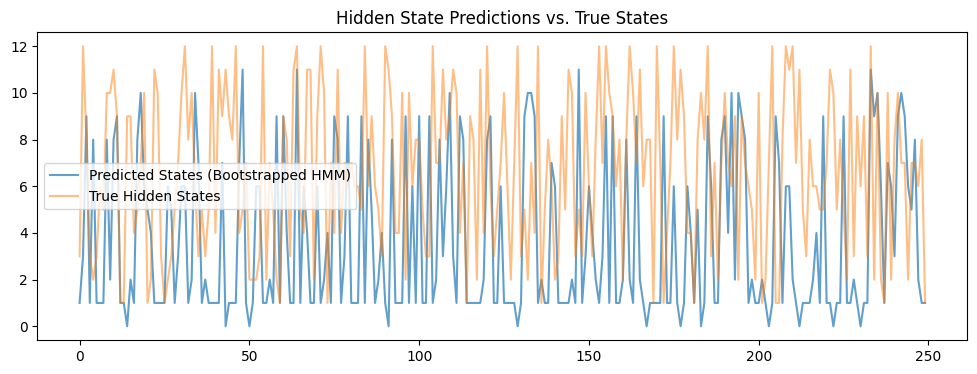

In [30]:
# ----- MODEL EVALUATION -----
# Log-Likelihood Calculation
log_likelihood = model_hybrid.score(X_test)
print(f"Log-Likelihood: {log_likelihood:.2f}")

# True Hidden States
true_hidden_states = test_data['Purchase_Month'].values  # Assuming month is true hidden state

# Accuracy Calculation
accuracy = np.sum(pred == true_hidden_states) / len(true_hidden_states)
print(f"Accuracy: {accuracy:.2%}")
print(f"Best accuracy: {model_acc:.2%}")
if (accuracy > model_acc):
    print("Accuracy is better than our previous best.")
    model_acc = accuracy
else:
    print("Accuracy is worse than our previous best.")

# Distribution Comparison
print("True State Distribution:\n", pd.Series(true_hidden_states).value_counts(normalize=True))
print("Predicted State Distribution:\n", pd.Series(pred).value_counts(normalize=True))

# Visualization: Hidden State Predictions vs. True Hidden States
plt.figure(figsize=(12, 4))
plt.plot(pred[:250], label='Predicted States (Bootstrapped HMM)', alpha=0.7)
plt.plot(true_hidden_states[:250], label='True Hidden States', alpha=0.5)
plt.title('Hidden State Predictions vs. True States')
plt.legend()
plt.show()

 Random Baseline Accuracy: 8.47%


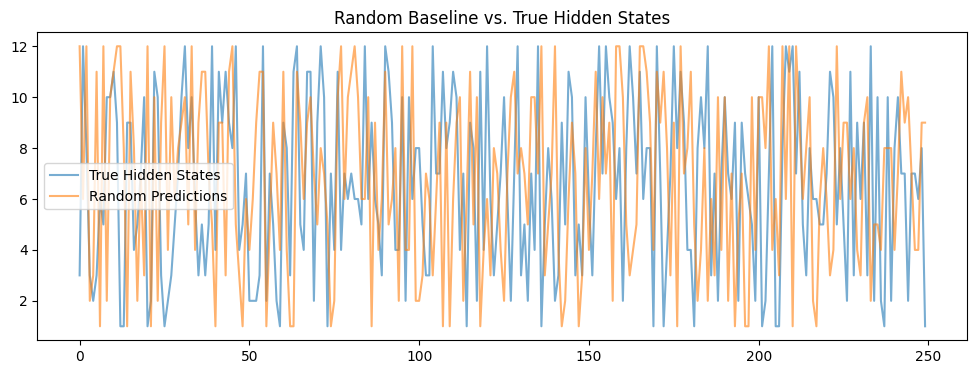

In [26]:
true_hidden_states = test_data['Purchase_Month'].values

# Randomly predict hidden states (1 to 12)
random_predictions = np.random.randint(1, n_hidden_states + 1, size=len(true_hidden_states))

# Calculate accuracy
accuracy = np.mean(random_predictions == true_hidden_states) * 100
print(f" Random Baseline Accuracy: {accuracy:.2f}%")

# Visualizing the comparison
plt.figure(figsize=(12, 4))
plt.plot(true_hidden_states[:250], label='True Hidden States', alpha=0.6)
plt.plot(random_predictions[:250], label='Random Predictions', alpha=0.6)
plt.title('Random Baseline vs. True Hidden States')
plt.legend()
plt.show()

In [40]:
# Initialize agent with a trained HMM model and CPTs
cpts = {
    'P(Product_Category | CustomerID)': cpt_productCategory_by_customer,
    'P(Total_Spend | CustomerID, Purchase_Month)': cpt_totalSpend_by_customer_month,
    'P(Avg_Price | CustomerID, Product_Category)': cpt_price_by_customerAndProductCategory,
    'P(Days_Since_Last_Purchase | CustomerID)': cpt_days_by_customer,
    'P(Used_Coupon | CustomerID, Product_Category)': cpt_coupon_by_customerAndProductCategory
}

agent = CustomerPurchaseAgent(model_hybrid, cpts, test_data)

# Test agent for a random customer with sample conditions
customer_id = data['CustomerID'].sample(1).values[0]
given_info = {'Purchase_Month': '12', 'Product_Category': 'Google'}
predictions = agent.predict_purchases(customer_id, given_info)
print(f"Predictions for Customer {customer_id}: {predictions}")

# Execute the evaluation
agent.evaluate_agent(test_data)

Predictions for Customer 13174.0: {'Likely_Product_Categories': 'Apparel', 'Total_Spend_Estimate': 0.0, 'Avg_Price_Estimate': 11.19, 'Days_Since_Last_Purchase': 226, 'Suggested_Spend_Strategy': 'Consider larger purchase due to long inactivity', 'Coupon_Use_Probability': 0.0}

 Predictions and Recommendations for First 5 Customers:

Customer ID: 17787.0
Predictions: {'Total_Spend_Estimate': 4660.74, 'Days_Since_Last_Purchase': 186, 'Suggested_Spend_Strategy': 'Consider larger purchase due to long inactivity'}
Actual Categories: Office, Apparel, Drinkware, Bags, Nest, Lifestyle, Nest-USA
Recommendations: []
----------
Customer ID: 16897.0
Predictions: {'Total_Spend_Estimate': 4571.31, 'Days_Since_Last_Purchase': 39, 'Suggested_Spend_Strategy': 'Steady smaller purchases recommended'}
Actual Categories: Nest-USA, Apparel, Nest
Recommendations: ['Black Friday detected - Consider exploring trending discounts in your favorite categories, Nest-USA, Apparel.']
----------
Customer ID: 14659.0
Pr